Universidade Estadual de Campinas – UNICAMP 

Disciplina: Ciência e Visualização de Dados em Saúde

                    Análise de dados da hanseníase: uma abordagem preditiva para a saúde pública

# Imports e configs de módulos

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import geopandas as gpd
import folium

C:\Users\mclar\AppData\Local\Temp\ipykernel_15060\3986538383.py:5: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 70)
%matplotlib inline
sns.set_style('darkgrid')
sns.set(font_scale=1.005)

# Datasets

In [4]:
df_hans = pd.read_csv('../data/interim/hans_interim.csv')

C:\Users\mclar\AppData\Local\Temp\ipykernel_15060\2667354285.py:1: DtypeWarning: Columns (5,9,13,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hans = pd.read_csv('../data/interim/hans_interim.csv')


In [5]:
df_hans.head()

,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_DIAG,ANO_NASC,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,SG_UF,ID_MN_RESI,ID_RG_RESI,ID_OCUPA_N,FORMACLINI,AVALIA_N,CLASSOPERA,MODOENTR,MODODETECT,BACILOSCOP,ESQ_INI_N,UFATUAL,ID_MUNI_AT,ID_UNID_AT,UFRESAT,MUNIRESAT,CLASSATUAL,AVAL_ATU_N,ESQ_ATU_N,EPIS_RACIO,NU_ANO,NU_LOTE_V,NU_LESOES,CONTREG,DOSE_RECEB,CONTEXAM,DTALTA_N,TPALTA_N
0,41.0,410304,1359.0,2741474.0,10/12/2000,1942,M,6.0,NaN,0.0,41.0,410304.0,1359.0,NaN,1.0,0.0,2.0,1.0,2.0,NaN,3.0,PR,410304.0,2741474.0,41.0,410304.0,2.0,0.0,3.0,NaN,2001,0.0,0.0,0.0,NaN,0.0,02/10/2002,1.0
1,41.0,410940,1359.0,2741369.0,23/12/2000,1956,M,6.0,1.0,0.0,41.0,410940.0,1359.0,NaN,4.0,2.0,2.0,6.0,NaN,NaN,3.0,PR,410940.0,2741369.0,41.0,410940.0,2.0,0.0,3.0,NaN,2001,0.0,0.0,3.0,NaN,2.0,19/12/2001,1.0
2,41.0,410940,1359.0,2741369.0,16/01/2001,1968,M,6.0,1.0,3.0,41.0,410940.0,1359.0,NaN,2.0,0.0,1.0,1.0,1.0,NaN,1.0,PR,410940.0,2741369.0,41.0,410940.0,1.0,0.0,1.0,NaN,2001,0.0,0.0,1.0,NaN,1.0,27/06/2001,1.0
3,41.0,411780,1359.0,2743116.0,08/01/2001,1960,F,9.0,NaN,3.0,41.0,411780.0,1359.0,NaN,1.0,1.0,2.0,1.0,2.0,NaN,3.0,PR,411780.0,2743116.0,41.0,411780.0,2.0,0.0,3.0,NaN,2001,0.0,0.0,3.0,NaN,3.0,28/01/2002,1.0
4,41.0,411780,1359.0,2743116.0,11/01/2000,1968,M,6.0,NaN,0.0,41.0,411780.0,1359.0,NaN,4.0,1.0,2.0,3.0,NaN,NaN,3.0,PR,411780.0,2743116.0,41.0,411780.0,2.0,2.0,3.0,NaN,2001,0.0,0.0,0.0,NaN,0.0,14/03/2002,1.0


In [6]:
df_hans.shape

(923238, 38)

# EDA

### Análise de casos por ano

In [7]:
df_hans['NU_ANO'].value_counts().sort_index()

2001    50668
2002    55108
2003    58880
2004    57529
2005    56738
2006    52241
2007    47081
2008    47470
2009    44937
2010    42629
2011    41486
2012    40897
2013    38254
2014    38439
2015    36051
2016    32325
2017    34920
2018    36765
2019    36610
2020    23775
2021    24954
2022    25481
Name: NU_ANO, dtype: int64

<AxesSubplot: >

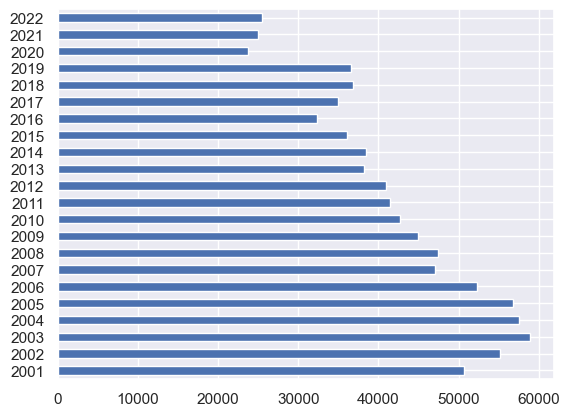

In [8]:
df_hans['NU_ANO'].value_counts().sort_index().plot.barh()

### Análise de casos por estado

In [9]:
df_hans_states = df_hans['UFATUAL'].value_counts().to_frame().reset_index()
df_hans_states = df_hans_states.rename(columns={'index': 'UF', 'UFATUAL': 'Contagem'})
df_hans_states.head()

,UF,Contagem
0,MA,102432
1,PA,100338
2,MT,83515
3,PE,71020
4,BA,66410


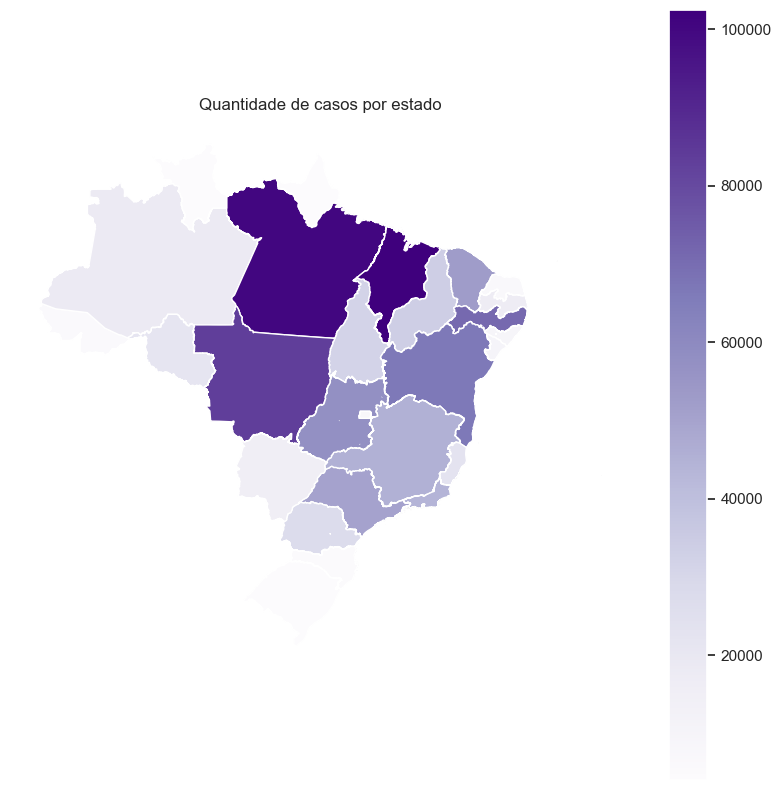

In [10]:
# Carrega o arquivo shapefile do mapa do Brasil
map = gpd.read_file('../assets/mapa/BR_UF_2022.shp')

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences = map.merge(df_hans_states, left_on='SIGLA_UF', right_on='UF')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences.plot(column='Contagem', cmap='Purples', ax=ax, legend=True)
ax.set_title('Quantidade de casos por estado')
ax.set_axis_off()
plt.show()

### Análise de casos por estado e gravidade

In [11]:
df_hans_severity = df_hans.groupby(['UFATUAL', 'AVALIA_N']).size().reset_index(name='Contagem')
df_hans_severity.head()

,UFATUAL,AVALIA_N,Contagem
0,AC,0.0,4427
1,AC,1.0,866
2,AC,2.0,387
3,AC,3.0,84
4,AL,0.0,5128


#### Grau 0:

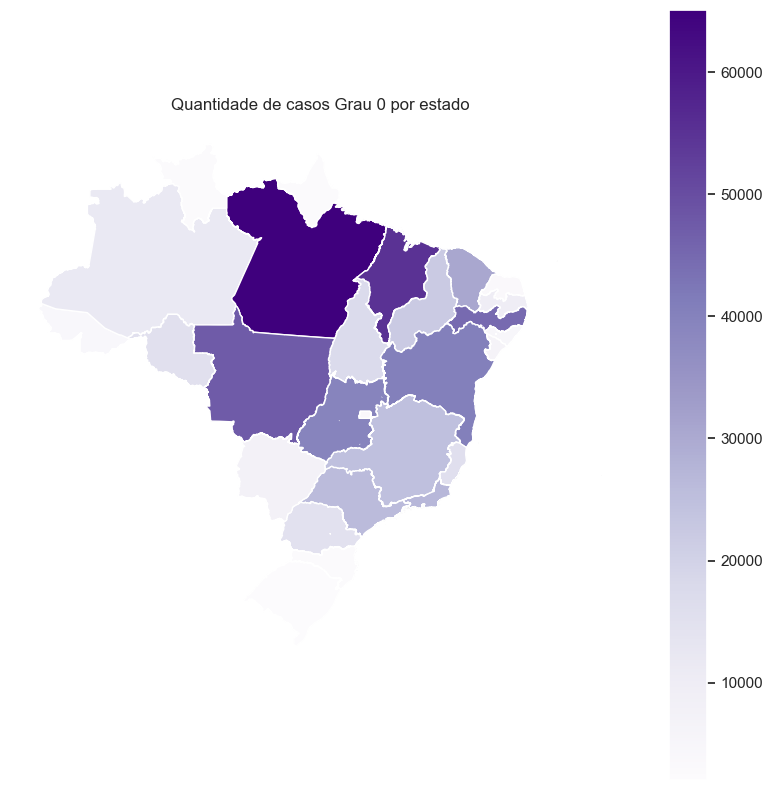

In [12]:
df_hans_severity_0 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 0].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_0 = map.merge(df_hans_severity_0, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_0.plot(column='Contagem', cmap='Purples', ax=ax, legend=True)
ax.set_title('Quantidade de casos Grau 0 por estado')
ax.set_axis_off()
plt.show()

#### Grau I:

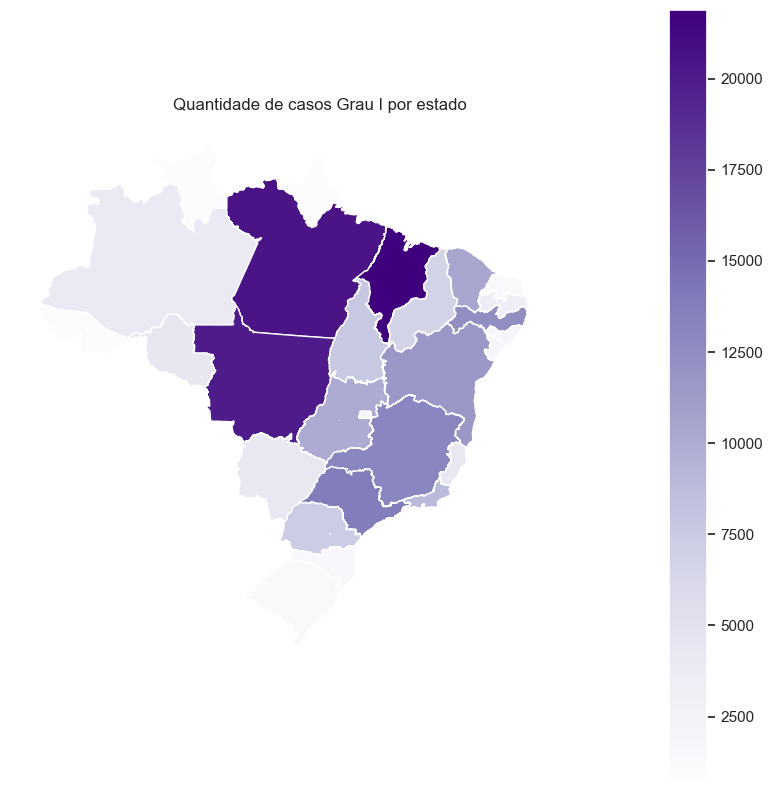

In [13]:
df_hans_severity_1 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 1].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_1 = map.merge(df_hans_severity_1, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_1.plot(column='Contagem', cmap='Purples', ax=ax, legend=True)
ax.set_title('Quantidade de casos Grau I por estado')
ax.set_axis_off()
plt.show()

#### Grau II:

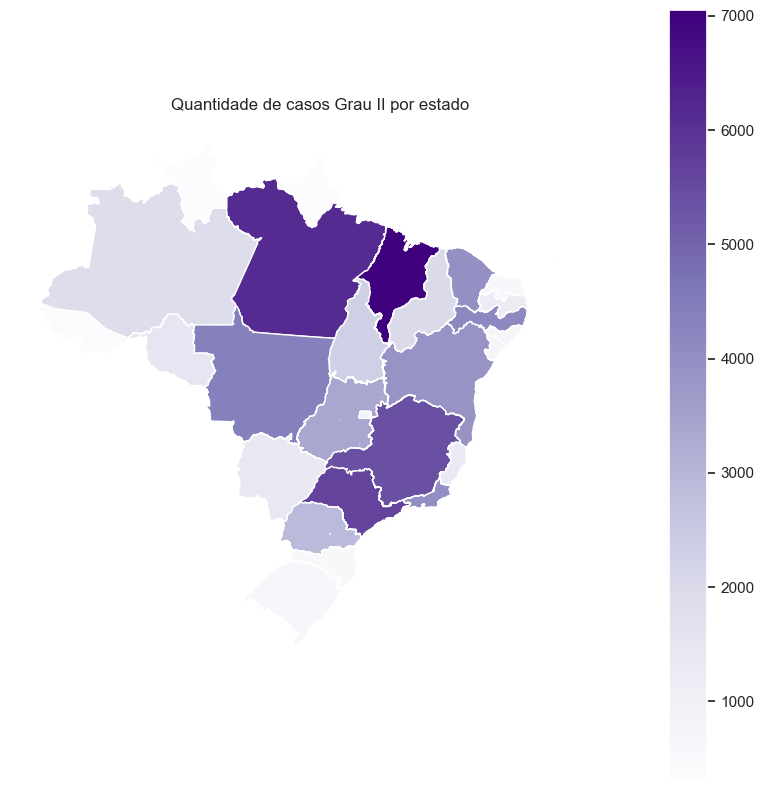

In [14]:
df_hans_severity_2 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 2].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_2 = map.merge(df_hans_severity_2, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_2.plot(column='Contagem', cmap='Purples', ax=ax, legend=True)
ax.set_title('Quantidade de casos Grau II por estado')
ax.set_axis_off()
plt.show()

### Análise do abandono

In [27]:
# Considerar apenas casos com desfecho: cura, óbito ou abandono
df_hans_tp_alta = df_hans[df_hans['TPALTA_N'].isin([1, 6, 7])]

<AxesSubplot: >

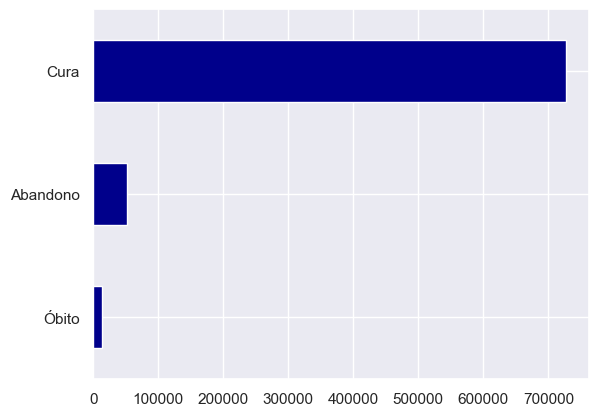

In [32]:
df_hans_outcome = df_hans_tp_alta.copy()
df_hans_outcome['TPALTA_N'] = df_hans_outcome['TPALTA_N'].replace({1: 'Cura', 6: 'Óbito', 7: 'Abandono'})
df_hans_outcome['TPALTA_N'].value_counts().sort_values().plot.barh(color='darkblue')

In [34]:
df_hans_tp_alta[df_hans_tp_alta['TPALTA_N'].isin([7])]

,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_DIAG,ANO_NASC,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,SG_UF,ID_MN_RESI,ID_RG_RESI,ID_OCUPA_N,FORMACLINI,AVALIA_N,CLASSOPERA,MODOENTR,MODODETECT,BACILOSCOP,ESQ_INI_N,UFATUAL,ID_MUNI_AT,ID_UNID_AT,UFRESAT,MUNIRESAT,CLASSATUAL,AVAL_ATU_N,ESQ_ATU_N,EPIS_RACIO,NU_ANO,NU_LOTE_V,NU_LESOES,CONTREG,DOSE_RECEB,CONTEXAM,DTALTA_N,TPALTA_N
32,52.0,521830,1784.0,2382784.0,06/12/2000,1977,F,9.0,NaN,0.0,52.0,521830.0,1784.0,NaN,4.0,0.0,2.0,1.0,9.0,NaN,3.0,GO,521830.0,2382784.0,52.0,521830.0,2.0,NaN,3.0,NaN,2001,0.0,0.0,1.0,NaN,1.0,15/01/2004,7.0
33,52.0,522070,1784.0,2382814.0,04/01/2001,1979,M,6.0,NaN,3.0,52.0,522070.0,1784.0,NaN,3.0,1.0,2.0,1.0,2.0,NaN,3.0,GO,522070.0,2382814.0,52.0,522070.0,1.0,NaN,3.0,NaN,2001,0.0,0.0,3.0,NaN,3.0,02/05/2011,7.0
34,52.0,521405,1788.0,2569744.0,24/01/2001,1979,M,6.0,NaN,3.0,52.0,521405.0,1788.0,NaN,2.0,0.0,1.0,1.0,1.0,NaN,1.0,GO,521405.0,2569744.0,52.0,521405.0,1.0,NaN,1.0,NaN,2001,0.0,0.0,4.0,NaN,2.0,15/06/2003,7.0
35,52.0,521405,1788.0,2569744.0,29/01/2001,1945,M,6.0,NaN,0.0,52.0,521405.0,1788.0,NaN,3.0,1.0,2.0,1.0,1.0,NaN,9.0,GO,521405.0,2569744.0,52.0,521405.0,2.0,NaN,3.0,NaN,2001,0.0,0.0,2.0,NaN,0.0,15/06/2003,7.0
40,52.0,520540,1791.0,2337649.0,23/01/2001,1957,M,6.0,NaN,3.0,52.0,520540.0,1791.0,NaN,4.0,0.0,2.0,1.0,1.0,NaN,3.0,GO,520540.0,2337649.0,52.0,520540.0,2.0,NaN,3.0,NaN,2001,0.0,0.0,3.0,NaN,3.0,28/09/2006,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923230,32.0,320530,32002.0,12092.0,19/10/2022,1997.0,M,6.0,1.0,5.0,32.0,320530.0,NaN,NaN,4.0,0.0,2.0,3.0,NaN,1.0,2.0,ES,320530.0,12092.0,32,320530.0,2.0,NaN,2.0,4.0,2022,NaN,6.0,2.0,9.0,0.0,01/12/2022,7.0
923231,32.0,320240,32002.0,895695.0,11/08/2022,1980.0,M,6.0,2.0,9.0,32.0,320240.0,NaN,NaN,2.0,0.0,1.0,1.0,1.0,2.0,1.0,ES,320240.0,895695.0,32,320240.0,1.0,NaN,1.0,4.0,2022,NaN,1.0,0.0,2.0,1.0,NaN,7.0
923232,32.0,320332,32004.0,3182711.0,12/04/2022,1971.0,F,5.0,4.0,8.0,32.0,320332.0,NaN,NaN,2.0,0.0,1.0,1.0,1.0,3.0,1.0,ES,320332.0,3182711.0,32,320332.0,1.0,0.0,1.0,4.0,2022,NaN,1.0,1.0,1.0,1.0,20/07/2022,7.0
923233,32.0,320090,32003.0,2445859.0,27/01/2022,1953.0,F,5.0,4.0,2.0,32.0,320090.0,NaN,NaN,1.0,0.0,1.0,1.0,2.0,2.0,1.0,ES,320090.0,2445859.0,32,320090.0,1.0,0.0,1.0,4.0,2022,NaN,2.0,2.0,1.0,NaN,26/08/2022,7.0
